In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.scripts import loading_virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
n_points = 4096

experiment_name = '6_virt_scan_chamfer_2fc_decoder_' + str(n_points) + 'pts'

do_training = True
do_plotting = True
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/', str(n_points), class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts'

In [5]:
train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
search_pattern = '.ply'

full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=25)

print '%d files containing complete point clouds were found.' % (len(full_pclouds), )


incomplete_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=25,
                                                      n_samples=n_points, search_pattern=search_pattern)
train_data = incomplete_data

6778 files containing complete point clouds were found.
40000 incomplete point clouds were loaded.


0.3623046875
0.113525390625


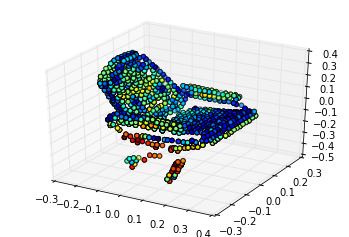

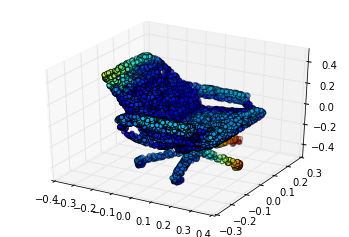

In [6]:
# TRY ME.
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

pp = incomplete_data.next_batch(1)
pinc = pp[2].reshape(n_points, 3)
pcom = pp[0].reshape(n_points, 3)

# accuracy_of_completion(pred_pcloud, gt_pcloud, thres=0.02, ret_dists=False):
    
score1, c1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=True)
print score1
score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)
print score2


Point_Cloud(points=pinc).plot(c=c1);
Point_Cloud(points=pcom).plot(c=c2);

In [7]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_points, 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 400,
                batch_size = 50,
                loss = 'chamfer',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [8]:
reset_tf_graph()
set_visible_GPUs([3])
ae = PointNetAutoEncoder(experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1])

('Epoch:', '0001', 'training time (minutes)=', '2.7348', 'loss=', '0.002651519')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0002', 'training time (minutes)=', '2.7340', 'loss=', '0.002036649')
('Epoch:', '0003', 'training time (minutes)=', '2.7567', 'loss=', '0.001861954')
('Epoch:', '0004', 'training time (minutes)=', '2.8458', 'loss=', '0.001741224')
('Epoch:', '0005', 'training time (minutes)=', '2.7589', 'loss=', '0.001652228')
('Epoch:', '0006', 'training time (minutes)=', '2.7614', 'loss=', '0.001588428')
('Epoch:', '0007', 'training time (minutes)=', '2.8729', 'loss=', '0.001536973')
('Epoch:', '0008', 'training time (minutes)=', '2.8072', 'loss=', '0.001498660')
('Epoch:', '0009', 'training time (minutes)=', '2.8044', 'loss=', '0.001467868')
('Epoch:', '0010', 'training time (minutes)=', '2.7006', 'loss=', '0.001437482')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0011', 'training time (minutes)=', '2.7472', 'loss=', '0.001413127')
('Epoch:', '0012', 'training time (minutes)=', '2.7603', 'loss=', '0.001390722')
('Epoch:', '0013', 'training time (minutes)=', '2.7206', 'loss=', '0.001371843')
('Epoch:', '0014', 'training time (minutes)=', '2.7428', 'loss=', '0.001353113')
('Epoch:', '0015', 'training time (minutes)=', '2.7500', 'loss=', '0.001336271')
('Epoch:', '0016', 'training time (minutes)=', '2.7088', 'loss=', '0.001320511')
('Epoch:', '0017', 'training time (minutes)=', '2.7446', 'loss=', '0.001306850')
('Epoch:', '0018', 'training time (minutes)=', '2.7320', 'loss=', '0.001296143')
('Epoch:', '0019', 'training time (minutes)=', '2.7430', 'loss=', '0.001282505')
('Epoch:', '0020', 'training time (minutes)=', '2.6954', 'loss=', '0.001272034')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-20 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0021', 'training time (minutes)=', '2.7849', 'loss=', '0.001261141')
('Epoch:', '0022', 'training time (minutes)=', '2.9270', 'loss=', '0.001253154')
('Epoch:', '0023', 'training time (minutes)=', '2.7046', 'loss=', '0.001242908')
('Epoch:', '0024', 'training time (minutes)=', '2.7003', 'loss=', '0.001235660')
('Epoch:', '0025', 'training time (minutes)=', '2.7408', 'loss=', '0.001228132')
('Epoch:', '0026', 'training time (minutes)=', '2.6809', 'loss=', '0.001219643')
('Epoch:', '0027', 'training time (minutes)=', '2.9248', 'loss=', '0.001212818')
('Epoch:', '0028', 'training time (minutes)=', '2.8221', 'loss=', '0.001206421')
('Epoch:', '0029', 'training time (minutes)=', '2.7116', 'loss=', '0.001199124')
('Epoch:', '0030', 'training time (minutes)=', '2.6785', 'loss=', '0.001193686')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-30 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0031', 'training time (minutes)=', '2.7110', 'loss=', '0.001185843')
('Epoch:', '0032', 'training time (minutes)=', '2.7912', 'loss=', '0.001180968')
('Epoch:', '0033', 'training time (minutes)=', '2.6820', 'loss=', '0.001176090')
('Epoch:', '0034', 'training time (minutes)=', '2.7330', 'loss=', '0.001167804')
('Epoch:', '0035', 'training time (minutes)=', '2.7512', 'loss=', '0.001164442')
('Epoch:', '0036', 'training time (minutes)=', '2.6738', 'loss=', '0.001159553')
('Epoch:', '0037', 'training time (minutes)=', '2.6776', 'loss=', '0.001154702')
('Epoch:', '0038', 'training time (minutes)=', '2.7442', 'loss=', '0.001150304')
('Epoch:', '0039', 'training time (minutes)=', '2.6636', 'loss=', '0.001144320')
('Epoch:', '0040', 'training time (minutes)=', '2.8419', 'loss=', '0.001140358')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-40 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0041', 'training time (minutes)=', '2.7247', 'loss=', '0.001135488')
('Epoch:', '0042', 'training time (minutes)=', '2.7248', 'loss=', '0.001130662')
('Epoch:', '0043', 'training time (minutes)=', '2.8159', 'loss=', '0.001127394')
('Epoch:', '0044', 'training time (minutes)=', '2.7613', 'loss=', '0.001123615')
('Epoch:', '0045', 'training time (minutes)=', '2.7638', 'loss=', '0.001121472')
('Epoch:', '0046', 'training time (minutes)=', '2.7576', 'loss=', '0.001115651')
('Epoch:', '0047', 'training time (minutes)=', '2.7979', 'loss=', '0.001110470')
('Epoch:', '0048', 'training time (minutes)=', '2.8242', 'loss=', '0.001109528')
('Epoch:', '0049', 'training time (minutes)=', '2.7684', 'loss=', '0.001105250')
('Epoch:', '0050', 'training time (minutes)=', '2.7810', 'loss=', '0.001101775')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-50 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0051', 'training time (minutes)=', '3.0480', 'loss=', '0.001098546')
('Epoch:', '0052', 'training time (minutes)=', '2.6402', 'loss=', '0.001093608')
('Epoch:', '0053', 'training time (minutes)=', '2.6111', 'loss=', '0.001089895')
('Epoch:', '0054', 'training time (minutes)=', '2.5974', 'loss=', '0.001087063')
('Epoch:', '0055', 'training time (minutes)=', '2.6616', 'loss=', '0.001084778')
('Epoch:', '0056', 'training time (minutes)=', '2.5966', 'loss=', '0.001080217')
('Epoch:', '0057', 'training time (minutes)=', '2.6017', 'loss=', '0.001078682')
('Epoch:', '0058', 'training time (minutes)=', '2.8251', 'loss=', '0.001075643')
('Epoch:', '0059', 'training time (minutes)=', '2.5908', 'loss=', '0.001073499')
('Epoch:', '0060', 'training time (minutes)=', '2.5991', 'loss=', '0.001069555')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-60 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0061', 'training time (minutes)=', '2.6708', 'loss=', '0.001066465')
('Epoch:', '0062', 'training time (minutes)=', '2.6074', 'loss=', '0.001064579')
('Epoch:', '0063', 'training time (minutes)=', '2.5938', 'loss=', '0.001061302')
('Epoch:', '0064', 'training time (minutes)=', '2.6645', 'loss=', '0.001059434')
('Epoch:', '0065', 'training time (minutes)=', '2.6624', 'loss=', '0.001056702')
('Epoch:', '0066', 'training time (minutes)=', '2.5825', 'loss=', '0.001053289')
('Epoch:', '0067', 'training time (minutes)=', '2.6505', 'loss=', '0.001052409')
('Epoch:', '0068', 'training time (minutes)=', '2.5971', 'loss=', '0.001048079')
('Epoch:', '0069', 'training time (minutes)=', '2.6257', 'loss=', '0.001046945')
('Epoch:', '0070', 'training time (minutes)=', '2.7419', 'loss=', '0.001043512')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-70 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0071', 'training time (minutes)=', '2.7536', 'loss=', '0.001040258')
('Epoch:', '0072', 'training time (minutes)=', '2.7153', 'loss=', '0.001036752')
('Epoch:', '0073', 'training time (minutes)=', '2.7075', 'loss=', '0.001034765')
('Epoch:', '0074', 'training time (minutes)=', '2.8169', 'loss=', '0.001034077')
('Epoch:', '0075', 'training time (minutes)=', '2.6002', 'loss=', '0.001030990')
('Epoch:', '0076', 'training time (minutes)=', '2.5909', 'loss=', '0.001029879')
('Epoch:', '0077', 'training time (minutes)=', '2.6667', 'loss=', '0.001028611')
('Epoch:', '0078', 'training time (minutes)=', '2.6373', 'loss=', '0.001025963')
('Epoch:', '0079', 'training time (minutes)=', '2.5971', 'loss=', '0.001021704')
('Epoch:', '0080', 'training time (minutes)=', '2.6621', 'loss=', '0.001022415')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-80 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0081', 'training time (minutes)=', '2.5998', 'loss=', '0.001018304')
('Epoch:', '0082', 'training time (minutes)=', '2.6342', 'loss=', '0.001014881')
('Epoch:', '0083', 'training time (minutes)=', '2.5832', 'loss=', '0.001015352')
('Epoch:', '0084', 'training time (minutes)=', '2.6377', 'loss=', '0.001011782')
('Epoch:', '0085', 'training time (minutes)=', '2.6131', 'loss=', '0.001012574')
('Epoch:', '0086', 'training time (minutes)=', '2.6356', 'loss=', '0.001009213')
('Epoch:', '0087', 'training time (minutes)=', '2.7797', 'loss=', '0.001007084')
('Epoch:', '0088', 'training time (minutes)=', '2.6573', 'loss=', '0.001005141')
('Epoch:', '0089', 'training time (minutes)=', '2.6720', 'loss=', '0.001004584')
('Epoch:', '0090', 'training time (minutes)=', '2.7910', 'loss=', '0.001002056')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-90 is not in all_model_checkpoint_paths. Manual

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0091', 'training time (minutes)=', '2.7199', 'loss=', '0.001000258')
('Epoch:', '0092', 'training time (minutes)=', '2.5985', 'loss=', '0.000998686')
('Epoch:', '0093', 'training time (minutes)=', '2.6393', 'loss=', '0.000995485')
('Epoch:', '0094', 'training time (minutes)=', '2.6017', 'loss=', '0.000995349')
('Epoch:', '0095', 'training time (minutes)=', '2.6455', 'loss=', '0.000992323')
('Epoch:', '0096', 'training time (minutes)=', '2.5930', 'loss=', '0.000990518')
('Epoch:', '0097', 'training time (minutes)=', '2.6629', 'loss=', '0.000989559')
('Epoch:', '0098', 'training time (minutes)=', '2.5954', 'loss=', '0.000988285')
('Epoch:', '0099', 'training time (minutes)=', '2.6003', 'loss=', '0.000986563')
('Epoch:', '0100', 'training time (minutes)=', '2.6493', 'loss=', '0.000982677')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-100 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0101', 'training time (minutes)=', '2.6004', 'loss=', '0.000981658')
('Epoch:', '0102', 'training time (minutes)=', '2.6499', 'loss=', '0.000980915')
('Epoch:', '0103', 'training time (minutes)=', '2.5970', 'loss=', '0.000978120')
('Epoch:', '0104', 'training time (minutes)=', '2.6353', 'loss=', '0.000977837')
('Epoch:', '0105', 'training time (minutes)=', '2.6642', 'loss=', '0.000976104')
('Epoch:', '0106', 'training time (minutes)=', '2.6238', 'loss=', '0.000975324')
('Epoch:', '0107', 'training time (minutes)=', '2.6223', 'loss=', '0.000973710')
('Epoch:', '0108', 'training time (minutes)=', '2.6978', 'loss=', '0.000970819')
('Epoch:', '0109', 'training time (minutes)=', '2.6052', 'loss=', '0.000970578')
('Epoch:', '0110', 'training time (minutes)=', '2.6586', 'loss=', '0.000969878')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-110 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0111', 'training time (minutes)=', '2.5988', 'loss=', '0.000966880')
('Epoch:', '0112', 'training time (minutes)=', '2.6581', 'loss=', '0.000966113')
('Epoch:', '0113', 'training time (minutes)=', '2.5950', 'loss=', '0.000964823')
('Epoch:', '0114', 'training time (minutes)=', '2.6449', 'loss=', '0.000962762')
('Epoch:', '0115', 'training time (minutes)=', '2.6003', 'loss=', '0.000960818')
('Epoch:', '0116', 'training time (minutes)=', '2.6384', 'loss=', '0.000959795')
('Epoch:', '0117', 'training time (minutes)=', '2.5994', 'loss=', '0.000958666')
('Epoch:', '0118', 'training time (minutes)=', '2.6032', 'loss=', '0.000957275')
('Epoch:', '0119', 'training time (minutes)=', '2.6672', 'loss=', '0.000955805')
('Epoch:', '0120', 'training time (minutes)=', '2.7299', 'loss=', '0.000956029')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-120 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0121', 'training time (minutes)=', '2.6897', 'loss=', '0.000953039')
('Epoch:', '0122', 'training time (minutes)=', '2.6831', 'loss=', '0.000950615')
('Epoch:', '0123', 'training time (minutes)=', '2.7387', 'loss=', '0.000949395')
('Epoch:', '0124', 'training time (minutes)=', '2.7027', 'loss=', '0.000950624')
('Epoch:', '0125', 'training time (minutes)=', '2.7245', 'loss=', '0.000948705')
('Epoch:', '0126', 'training time (minutes)=', '2.6530', 'loss=', '0.000945686')
('Epoch:', '0127', 'training time (minutes)=', '2.6484', 'loss=', '0.000945548')
('Epoch:', '0128', 'training time (minutes)=', '2.6004', 'loss=', '0.000945479')
('Epoch:', '0129', 'training time (minutes)=', '2.6561', 'loss=', '0.000943351')
('Epoch:', '0130', 'training time (minutes)=', '2.6067', 'loss=', '0.000942453')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-130 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0131', 'training time (minutes)=', '2.6343', 'loss=', '0.000940922')
('Epoch:', '0132', 'training time (minutes)=', '2.7855', 'loss=', '0.000939079')
('Epoch:', '0133', 'training time (minutes)=', '2.6054', 'loss=', '0.000938140')
('Epoch:', '0134', 'training time (minutes)=', '2.7411', 'loss=', '0.000936881')
('Epoch:', '0135', 'training time (minutes)=', '2.7503', 'loss=', '0.000935528')
('Epoch:', '0136', 'training time (minutes)=', '2.7396', 'loss=', '0.000936375')
('Epoch:', '0137', 'training time (minutes)=', '2.6029', 'loss=', '0.000933238')
('Epoch:', '0138', 'training time (minutes)=', '2.6462', 'loss=', '0.000931200')
('Epoch:', '0139', 'training time (minutes)=', '2.5930', 'loss=', '0.000933147')
('Epoch:', '0140', 'training time (minutes)=', '2.6405', 'loss=', '0.000929327')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-140 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0141', 'training time (minutes)=', '2.6071', 'loss=', '0.000928717')
('Epoch:', '0142', 'training time (minutes)=', '2.5856', 'loss=', '0.000928055')
('Epoch:', '0143', 'training time (minutes)=', '2.6691', 'loss=', '0.000928123')
('Epoch:', '0144', 'training time (minutes)=', '2.5974', 'loss=', '0.000925523')
('Epoch:', '0145', 'training time (minutes)=', '2.6486', 'loss=', '0.000923942')
('Epoch:', '0146', 'training time (minutes)=', '2.6067', 'loss=', '0.000924116')
('Epoch:', '0147', 'training time (minutes)=', '2.6304', 'loss=', '0.000922483')
('Epoch:', '0148', 'training time (minutes)=', '2.5988', 'loss=', '0.000922092')
('Epoch:', '0149', 'training time (minutes)=', '2.6527', 'loss=', '0.000920467')
('Epoch:', '0150', 'training time (minutes)=', '2.6520', 'loss=', '0.000918949')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-150 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0151', 'training time (minutes)=', '2.5910', 'loss=', '0.000917892')
('Epoch:', '0152', 'training time (minutes)=', '2.6319', 'loss=', '0.000917067')
('Epoch:', '0153', 'training time (minutes)=', '2.5917', 'loss=', '0.000916144')
('Epoch:', '0154', 'training time (minutes)=', '2.6464', 'loss=', '0.000914562')
('Epoch:', '0155', 'training time (minutes)=', '2.6019', 'loss=', '0.000913523')
('Epoch:', '0156', 'training time (minutes)=', '2.6381', 'loss=', '0.000913398')
('Epoch:', '0157', 'training time (minutes)=', '2.6016', 'loss=', '0.000911533')
('Epoch:', '0158', 'training time (minutes)=', '2.5988', 'loss=', '0.000911346')
('Epoch:', '0159', 'training time (minutes)=', '2.7006', 'loss=', '0.000909874')
('Epoch:', '0160', 'training time (minutes)=', '2.5995', 'loss=', '0.000908671')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-160 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0161', 'training time (minutes)=', '2.6404', 'loss=', '0.000905664')
('Epoch:', '0162', 'training time (minutes)=', '2.6005', 'loss=', '0.000906541')
('Epoch:', '0163', 'training time (minutes)=', '2.6547', 'loss=', '0.000905606')
('Epoch:', '0164', 'training time (minutes)=', '2.5874', 'loss=', '0.000904656')
('Epoch:', '0165', 'training time (minutes)=', '2.6943', 'loss=', '0.000904114')
('Epoch:', '0166', 'training time (minutes)=', '2.6595', 'loss=', '0.000902315')
('Epoch:', '0167', 'training time (minutes)=', '2.6345', 'loss=', '0.000901325')
('Epoch:', '0168', 'training time (minutes)=', '2.5898', 'loss=', '0.000902036')
('Epoch:', '0169', 'training time (minutes)=', '2.5964', 'loss=', '0.000899167')
('Epoch:', '0170', 'training time (minutes)=', '2.6491', 'loss=', '0.000899254')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-170 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0171', 'training time (minutes)=', '2.6631', 'loss=', '0.000899086')
('Epoch:', '0172', 'training time (minutes)=', '2.6320', 'loss=', '0.000895661')
('Epoch:', '0173', 'training time (minutes)=', '2.7338', 'loss=', '0.000897447')
('Epoch:', '0174', 'training time (minutes)=', '2.7333', 'loss=', '0.000894517')
('Epoch:', '0175', 'training time (minutes)=', '2.6896', 'loss=', '0.000894149')
('Epoch:', '0176', 'training time (minutes)=', '2.6785', 'loss=', '0.000894424')
('Epoch:', '0177', 'training time (minutes)=', '2.7570', 'loss=', '0.000892669')
('Epoch:', '0178', 'training time (minutes)=', '2.7042', 'loss=', '0.000891505')
('Epoch:', '0179', 'training time (minutes)=', '2.7418', 'loss=', '0.000891441')
('Epoch:', '0180', 'training time (minutes)=', '2.8898', 'loss=', '0.000888699')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-180 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0181', 'training time (minutes)=', '2.7406', 'loss=', '0.000890141')
('Epoch:', '0182', 'training time (minutes)=', '2.7259', 'loss=', '0.000887911')
('Epoch:', '0183', 'training time (minutes)=', '2.7766', 'loss=', '0.000887918')
('Epoch:', '0184', 'training time (minutes)=', '2.7870', 'loss=', '0.000886450')
('Epoch:', '0185', 'training time (minutes)=', '2.7400', 'loss=', '0.000885559')
('Epoch:', '0186', 'training time (minutes)=', '2.6935', 'loss=', '0.000885218')
('Epoch:', '0187', 'training time (minutes)=', '2.6752', 'loss=', '0.000885035')
('Epoch:', '0188', 'training time (minutes)=', '2.7048', 'loss=', '0.000882603')
('Epoch:', '0189', 'training time (minutes)=', '2.6702', 'loss=', '0.000882141')
('Epoch:', '0190', 'training time (minutes)=', '2.8208', 'loss=', '0.000880820')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-190 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0191', 'training time (minutes)=', '2.6973', 'loss=', '0.000880005')
('Epoch:', '0192', 'training time (minutes)=', '2.6381', 'loss=', '0.000880046')
('Epoch:', '0193', 'training time (minutes)=', '2.7839', 'loss=', '0.000879383')
('Epoch:', '0194', 'training time (minutes)=', '2.6154', 'loss=', '0.000878293')
('Epoch:', '0195', 'training time (minutes)=', '2.6555', 'loss=', '0.000877686')
('Epoch:', '0196', 'training time (minutes)=', '2.6143', 'loss=', '0.000875643')
('Epoch:', '0197', 'training time (minutes)=', '2.6143', 'loss=', '0.000876557')
('Epoch:', '0198', 'training time (minutes)=', '2.6832', 'loss=', '0.000875299')
('Epoch:', '0199', 'training time (minutes)=', '2.6960', 'loss=', '0.000873382')
('Epoch:', '0200', 'training time (minutes)=', '2.7042', 'loss=', '0.000873369')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-200 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0201', 'training time (minutes)=', '2.7914', 'loss=', '0.000871691')
('Epoch:', '0202', 'training time (minutes)=', '2.8017', 'loss=', '0.000871100')
('Epoch:', '0203', 'training time (minutes)=', '2.7180', 'loss=', '0.000870468')
('Epoch:', '0204', 'training time (minutes)=', '2.7566', 'loss=', '0.000870101')
('Epoch:', '0205', 'training time (minutes)=', '2.7754', 'loss=', '0.000870132')
('Epoch:', '0206', 'training time (minutes)=', '2.7677', 'loss=', '0.000868308')
('Epoch:', '0207', 'training time (minutes)=', '2.7468', 'loss=', '0.000866817')
('Epoch:', '0208', 'training time (minutes)=', '2.7430', 'loss=', '0.000867299')
('Epoch:', '0209', 'training time (minutes)=', '2.6948', 'loss=', '0.000865957')
('Epoch:', '0210', 'training time (minutes)=', '2.6363', 'loss=', '0.000865604')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-210 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0211', 'training time (minutes)=', '2.7619', 'loss=', '0.000865072')
('Epoch:', '0212', 'training time (minutes)=', '2.7887', 'loss=', '0.000862788')
('Epoch:', '0213', 'training time (minutes)=', '2.7990', 'loss=', '0.000863797')
('Epoch:', '0214', 'training time (minutes)=', '2.6881', 'loss=', '0.000863572')
('Epoch:', '0215', 'training time (minutes)=', '2.7422', 'loss=', '0.000861327')
('Epoch:', '0216', 'training time (minutes)=', '2.6956', 'loss=', '0.000861435')
('Epoch:', '0217', 'training time (minutes)=', '2.6462', 'loss=', '0.000858582')
('Epoch:', '0218', 'training time (minutes)=', '2.6691', 'loss=', '0.000858964')
('Epoch:', '0219', 'training time (minutes)=', '2.7663', 'loss=', '0.000859284')
('Epoch:', '0220', 'training time (minutes)=', '2.7820', 'loss=', '0.000859025')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-220 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0221', 'training time (minutes)=', '2.7408', 'loss=', '0.000856098')
('Epoch:', '0222', 'training time (minutes)=', '2.7582', 'loss=', '0.000855928')
('Epoch:', '0223', 'training time (minutes)=', '2.7942', 'loss=', '0.000855355')
('Epoch:', '0224', 'training time (minutes)=', '2.6438', 'loss=', '0.000854363')
('Epoch:', '0225', 'training time (minutes)=', '2.6406', 'loss=', '0.000854086')
('Epoch:', '0226', 'training time (minutes)=', '2.6527', 'loss=', '0.000853445')
('Epoch:', '0227', 'training time (minutes)=', '2.7817', 'loss=', '0.000851692')
('Epoch:', '0228', 'training time (minutes)=', '2.6580', 'loss=', '0.000852860')
('Epoch:', '0229', 'training time (minutes)=', '2.7363', 'loss=', '0.000850407')
('Epoch:', '0230', 'training time (minutes)=', '2.7793', 'loss=', '0.000850365')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-230 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0231', 'training time (minutes)=', '2.6592', 'loss=', '0.000851903')
('Epoch:', '0232', 'training time (minutes)=', '2.6577', 'loss=', '0.000849696')
('Epoch:', '0233', 'training time (minutes)=', '2.6972', 'loss=', '0.000848746')
('Epoch:', '0234', 'training time (minutes)=', '2.6264', 'loss=', '0.000848194')
('Epoch:', '0235', 'training time (minutes)=', '2.7163', 'loss=', '0.000847446')
('Epoch:', '0236', 'training time (minutes)=', '2.6485', 'loss=', '0.000846006')
('Epoch:', '0237', 'training time (minutes)=', '2.7672', 'loss=', '0.000847313')
('Epoch:', '0238', 'training time (minutes)=', '2.8228', 'loss=', '0.000844300')
('Epoch:', '0239', 'training time (minutes)=', '2.6742', 'loss=', '0.000845176')
('Epoch:', '0240', 'training time (minutes)=', '2.9232', 'loss=', '0.000843802')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-240 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0241', 'training time (minutes)=', '2.7008', 'loss=', '0.000843941')
('Epoch:', '0242', 'training time (minutes)=', '2.8447', 'loss=', '0.000842026')
('Epoch:', '0243', 'training time (minutes)=', '2.8814', 'loss=', '0.000841328')
('Epoch:', '0244', 'training time (minutes)=', '2.8257', 'loss=', '0.000840684')
('Epoch:', '0245', 'training time (minutes)=', '2.6464', 'loss=', '0.000840710')
('Epoch:', '0246', 'training time (minutes)=', '2.6631', 'loss=', '0.000838864')
('Epoch:', '0247', 'training time (minutes)=', '2.6502', 'loss=', '0.000838065')
('Epoch:', '0248', 'training time (minutes)=', '2.6440', 'loss=', '0.000838603')
('Epoch:', '0249', 'training time (minutes)=', '2.6352', 'loss=', '0.000837309')
('Epoch:', '0250', 'training time (minutes)=', '2.9335', 'loss=', '0.000836989')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-250 is not in all_model_checkpoint_paths. Manua

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/6_virt_scan_chamfer_2fc_decoder_4096pts/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0251', 'training time (minutes)=', '2.6381', 'loss=', '0.000836566')
('Epoch:', '0252', 'training time (minutes)=', '2.6538', 'loss=', '0.000836238')


KeyboardInterrupt: 

In [9]:
test_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-test.txt'
test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=24,
                                                      n_samples=n_points, search_pattern=search_pattern)

8000 incomplete point clouds were loaded.


In [11]:
reconstructions, losses, feed_data, ids, original_data = ae.evaluate(test_data, conf)
n_examples = len(reconstructions)
pred_scores = np.zeros((n_examples, 2))
bline_scores = np.zeros((n_examples, 2))

for i in xrange(n_examples):
    full_gt = original_data[i]
    pred = reconstructions[i]

    bline_scores[i, 0], _ = accuracy_of_completion(feed_data[i], full_gt, thres=0.02, ret_dists=False)
    bline_scores[i, 1], _ = coverage_of_completion(full_gt, feed_data[i], thres=0.02, ret_dists=False)

    pred_scores[i, 0], _ = accuracy_of_completion(pred, full_gt, thres=0.02, ret_dists=False)
    pred_scores[i, 1], _ = coverage_of_completion(full_gt, pred, thres=0.02, ret_dists=False)

In [12]:
print np.mean(bline_scores[:,0]), np.mean(bline_scores[:,1])
print np.mean(pred_scores[:,0]), np.mean(pred_scores[:,1])

0.49576574707 0.476999664307
0.69701385498 0.630715301514


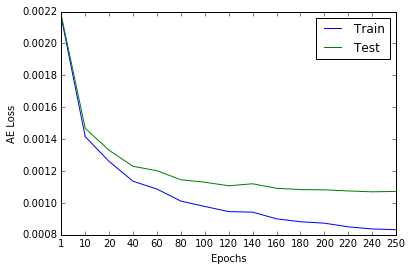

In [10]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)